<a href="https://colab.research.google.com/github/Sujo04/Email-Spam-Detection/blob/main/Email_Spam_Detection_with_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We've all been the recipient of spam emails before. Spam mail, or junk mail, is a type of email that is sent to a massive number of users at one time, frequently containing cryptic messages, scams, or most dangerously, phishing content.In this Project,I use Python to build an email spam detector. Then, use machine learning to train the spam detector to recognize and classify emails into spam and non-spam.

In [ ]:
# Import necessary libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from imblearn.over_sampling import SMOTE
import nltk
from nltk.corpus import stopwords
from collections import Counter

# Libraries for visualisation

import matplotlib.pyplot as plt


In [ ]:
# Download the stopwords dataset

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Load the Dataset**

In [ ]:
# Load the dataset
df = pd.read_csv("/content/spam.csv",encoding='latin-1')

# Display the first few rows of the dataset
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
# Drop unnecessary columns from the DataFrame

columns_to_drop = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"]
df.drop(columns=columns_to_drop, inplace=True)

In [ ]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


**Exploring the Dataset**

In [ ]:
df

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
df.shape

(5572, 2)

In [ ]:
df.describe()

,v1,v2
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [ ]:
df.isnull().sum()

Category    0
Message     0
dtype: int64

In [ ]:
df.columns

Index(['v1', 'v2'], dtype='object')

In [ ]:
# Rename the columns "v1 and "v2" to new names

new_column_names = {"v1":"Category","v2":"Message"}
df.rename(columns = new_column_names,inplace = True)

In [ ]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.duplicated().sum()

403

In [ ]:
df.drop_duplicates(inplace = True)

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.value_counts("Category")

Category
ham     4516
spam     653
Name: count, dtype: int64

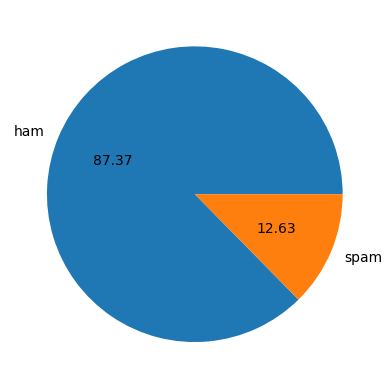

In [ ]:
plt.pie(df['Category'].value_counts(),labels=['ham','spam'],autopct='%0.2f')
plt.show()

We can see overrepresentation of non-spam(ham) messeges. we may have to do Class Imbalance techniques during modelling[SMOTE].

**Data Preprocessing**

label encoding

In [ ]:
# Import label encoder
from sklearn import preprocessing

# label_encoder object knows
# how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
df['Category']= label_encoder.fit_transform(df['Category'])

df['Category'].unique()

array([1, 0])

In [ ]:
# Separate the feature (message) and target (category) data

X = df["Message"]
Y = df["Category"]

In [ ]:
X

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: Message, Length: 5169, dtype: object

In [ ]:
Y

0       1
1       1
2       0
3       1
4       1
       ..
5567    0
5568    1
5569    1
5570    1
5571    1
Name: Category, Length: 5169, dtype: int64

Splitting the data into training data and test data

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 3)

In [ ]:
# Print the shape of X
print(X.shape)


(5169,)


In [ ]:
# Print the shape of X_train and X_test
print(X_train.shape)
print(X_test.shape)

(4135,)
(1034,)


**Feature Extraction**

TF-IDF Vectorizer

In [ ]:
# Initialize TF-IDF Vectorizer
feature_extraction = TfidfVectorizer(min_df=1, stop_words="english", lowercase=True)

In [ ]:
# Feature extraction for training and testing data
X_train_features = feature_extraction.transform(X_train)
X_test_features = feature_extraction.transform(X_test)

In [ ]:
print(X_train)

4443                       COME BACK TO TAMPA FFFFUUUUUUU
982     Congrats! 2 mobile 3G Videophones R yours. cal...
3822    Please protect yourself from e-threats. SIB ne...
3924       As if i wasn't having enough trouble sleeping.
4927    Just hopeing that wasnÛ÷t too pissed up to re...
                              ...                        
806      sure, but make sure he knows we ain't smokin yet
990                                          26th OF JULY
1723    Hi Jon, Pete here, Ive bin 2 Spain recently & ...
3519    No it will reach by 9 only. She telling she wi...
1745    IåÕm cool ta luv but v.tired 2 cause i have be...
Name: Message, Length: 4135, dtype: object


In [ ]:
print(X_train_features)

  (0, 6409)	0.5950532917415522
  (0, 2697)	0.7205755344386542
  (0, 1825)	0.35592482233751443
  (1, 7137)	0.24133495616477563
  (1, 6941)	0.27399320458839144
  (1, 6940)	0.27399320458839144
  (1, 5438)	0.27399320458839144
  (1, 5036)	0.27399320458839144
  (1, 4984)	0.19732502227978832
  (1, 4583)	0.27399320458839144
  (1, 4438)	0.22516921191243092
  (1, 4333)	0.15929709793058355
  (1, 4180)	0.23390504161994488
  (1, 3610)	0.27399320458839144
  (1, 2920)	0.23390504161994488
  (1, 2274)	0.27399320458839144
  (1, 1885)	0.22516921191243092
  (1, 453)	0.25698446420786897
  (1, 203)	0.27399320458839144
  (2, 6559)	0.2789171638390544
  (2, 5976)	0.1902832473629628
  (2, 5865)	0.29266038116418563
  (2, 5786)	0.2616027576860373
  (2, 5738)	0.29266038116418563
  (2, 5207)	0.29266038116418563
  :	:
  (4132, 504)	0.2305378257061908
  (4132, 278)	0.1968076536707758
  (4132, 2)	0.24189722502294153
  (4133, 6457)	0.6154177820886059
  (4133, 5320)	0.5530764956488926
  (4133, 3771)	0.36842584696755415


In [ ]:
counter = Counter(Y_train)
print('Before',counter)

Before Counter({1: 3622, 0: 513})


In [ ]:
#class imbalance using SMOTE
smote= SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train_features, Y_train)

In [ ]:
counter = Counter(Y_train_resampled)
print('After',counter)

After Counter({1: 3622, 0: 3622})


**Model Selection and Training**

*Logistic Regresion*

In [ ]:
# Create and Fit Logistic Regression Model
model = LogisticRegression()
model.fit(X_train_resampled, Y_train_resampled)

LogisticRegression()

Evaluating the trained Model

In [ ]:
#Make predictions on the training data
predict_train_data=model.predict(X_train_resampled)

In [ ]:
#Model Evaluation
from sklearn.metrics import accuracy_score
accuracy_train_data=accuracy_score(Y_train_resampled,predict_train_data)
print("Accuracy on training data: ",accuracy_train_data)

Accuracy on training data:  0.9944781888459415


In [ ]:
# Make predictions on the testing data
predict_test_data=model.predict(X_test_features)

In [ ]:
#Model Evaluation
accuracy_test_data=accuracy_score(Y_test,predict_test_data)
print("acuuracy on test data: ",accuracy_test_data)

acuuracy on test data:  0.9806576402321083


**Test the model with an email messages**

In [ ]:
new_mail=["Be there in 10 minutes,I'm on the way"]
new_data_features=feature_extraction.transform(new_mail)
prediction=model.predict(new_data_features)
print(prediction)

if(prediction[0]==1):
    print("Ham Mail")
else:
    print("Spam Mail")


[1]
Ham Mail


In [ ]:
new_mail=["2 free tickets!"]
new_data_features=feature_extraction.transform(new_mail)
prediction=model.predict(new_data_features)
print(prediction)

if(prediction[0]==1):
    print("Ham Mail")
else:
    print("Spam Mail")


[0]
Spam Mail


**Confusion matrix**

In [ ]:
# Classification Report
print("Classification Report for Testing Data:")
print(classification_report(Y_test, predict_test_data))
print("cofusion matrix:")
print(confusion_matrix(Y_test, predict_test_data))

Classification Report for Testing Data:
              precision    recall  f1-score   support

           0       0.96      0.89      0.93       140
           1       0.98      0.99      0.99       894

    accuracy                           0.98      1034
   macro avg       0.97      0.94      0.96      1034
weighted avg       0.98      0.98      0.98      1034

cofusion matrix:
[[125  15]
 [  5 889]]
